In [1]:
%reload_ext cairo_jupyter

In [2]:
#!pip install ipdb ipython

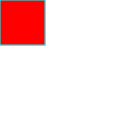

fin


In [3]:
import asyncio
import enum
import re
import sys
import traceback

from aiohttp import web

import cairo

from contextlib import contextmanager
from io import BytesIO
from pathlib import Path

from IPython.display import display, clear_output

FORMAT_PS = 'ps'
FORMAT_PDF = 'pdf'
FORMAT_PNG = 'png'
FORMAT_SVG = 'svg'
FORMAT_SVG_XML = 'svg_xml'

VALID_FORMATS = [FORMAT_PNG, FORMAT_SVG, FORMAT_SVG_XML]

ERROR_UNSUPPORTED_FORMAT = "Format must be FORMAT_PDF, FORMAT_PNG, FORMAT_PS, FORMAT_SVG or FORMAT_SVG_XML"



class RunObserver:
    """
    RunObserver is an event that lets code wait until the
    main loop has executed code.
    
    Code and execution status can then be retrieved.
    """
    def __init__(self):
        self._event = asyncio.Event()

    async def wait_until_after_run(self):
        """
        Wait until after source was ran
        """
        await self._event.wait()
    
    def source_executed(self, source, success, errors=None):
        """
        """
        self._event.set()

    
class SourceChanged(RunObserver):
    class Status(enum.Enum):
        WAITING = 1
        NOT_UPDATED = 2
        UPDATED_SUCCESSFULLY = 3
        UPDATED_BY_ANOTHER = 4

    def __init__(self, source):
        RunObserver.__init__(self)
        
        self.success = None
        self.errors = None
        
        self.source = source
        self.status = SourceChanged.Status.WAITING
        self.updated_by = None

    def source_updated(self, updated_by):
        """
        Called when source was updated, by this SourceChanged or
        another.
        
        If the update was from another then stop waiting immediately.
        """
        self.updated_by = updated_by
        if updated_by == self:
            self.status = SourceChanged.Status.UPDATED_SUCCESSFULLY
            # Don't stop waiting here
            return True
        
        if updated_by is None :
            self.status = SourceChanged.Status.NOT_UPDATED
        elif updated_by != self:
            self.status = SourceChanged.Status.UPDATED_BY_ANOTHER
        self._event.set()
      
    def source_executed(self, source, success, errors=None):
        """
        """
        self.source = source
        self.success = success
        self.errors = errors
        self._event.set()

      
        
# Shoebot Grammar        
class Grob:
    def __init__(self, ctx):
        self._ctx = ctx

#  nodebox does:
#     def draw(self):
#         self._ctx.append(self)

class ColorMixin:
    def __init__(self, fill=None, stroke=None, blendmode=None, **kwargs):
        self._fill = fill
        self._stroke = stroke
        self._blendmode = blendmode

# TODO have state internal ?  ColorState, TranslationState etc ?
# class PathState(ColorState, TranslationState)
# self._state = PathState(....)

MOVETO = "moveto"
RMOVETO = "rmoveto"
LINETO = "lineto"
RLINETO = "rlineto"
CURVETO = "curveto"
RCURVETO = "rcurveto"
ARC = "arc"
ELLIPSE = "ellipse"
CLOSE = "close"


class Point:
    def __init__(self, *args):
        if len(args) == 2:
            self.x, self.y = args
        elif len(args) == 1:
            self.x, self.y = args[0]
        elif len(args) == 0:
            self.x = self.y = 0.0
        else:
            raise ValueError("Point accepts 0, 1, or 2 arguments.")


class PathElement:
    # Taken from Nodebox and extended.

    def __init__(self, cmd=None, pts=None):
        self.cmd = cmd
        if cmd in (MOVETO, RMOVETO):
            assert len(pts) == 1
            self.x, self.y = pts[0]
            self.ctrl1 = Point(pts[0])
            self.ctrl2 = Point(pts[0])
        elif cmd in (LINETO, RLINETO):
            assert len(pts) == 1
            self.x, self.y = pts[0]
            self.ctrl1 = Point(pts[0])
            self.ctrl2 = Point(pts[0])
        elif cmd in (CURVETO, RCURVETO):
            assert len(pts) == 3
            self.ctrl1 = Point(pts[0])
            self.ctrl2 = Point(pts[1])
            self.x, self.y = pts[2]
        elif cmd == CLOSE:
            assert pts is None or len(pts) == 0
            self.x = self.y = 0.0
            self.ctrl1 = Point(0.0, 0.0)
            self.ctrl2 = Point(0.0, 0.0)
        else:
            self.x = self.y = 0.0
            self.ctrl1 = Point()
            self.ctrl2 = Point()
            
    def as_cairo(self, ctx):
        """
        Run command corresponding to this PathElement on a cairo Context.
        
        """
        if self.cmd == MOVETO:
            ctx.move_to(self.x, self.y)
        elif self.cmd == RMOVETO:
            # actually dx, dy
            ctx.rel_move_to(self.x, self.y)
        elif self.cmd == LINETO:
            ctx.line_to(self.x, self.y)
        elif self.cmd == RLINETO:
            # actually dx, dy
            ctx.rel_line_to(self.x, self.y)
        elif self.cmd == CURVETO:
            ctx.curve_to(self.x, self.y,
                         self.ctrl1.x, self.ctrl1.y,
                         self.ctrl2.x, self.ctrl2.y)
        elif self.cmd == RCURVETO:
            # actually dx, dy
            ctx.rel_curve_to(self.x, self.y,
                             self.ctrl1.x, self.ctrl1.y,
                             self.ctrl2.x, self.ctrl2.y)
        elif self.cmd == CLOSE:
            ctx.close_path()

    def __repr__(self):
        if self.cmd == MOVETO:
            return "PathElement(MOVETO, ((%.3f, %.3f),))" % (self.x, self.y)
        elif self.cmd == RMOVETO:
            return "PathElement(RMOVETO, ((%.3f, %.3f),))" % (self.x, self.y)
        elif self.cmd == LINETO:
            return "PathElement(LINETO, ((%.3f, %.3f),))" % (self.x, self.y)
        elif self.cmd == RLINETO:
            return "PathElement(RLINETO, ((%.3f, %.3f),))" % (self.x, self.y)
        elif self.cmd == CURVETO:
            return "PathElement(CURVETO, ((%.3f, %.3f), (%.3f, %s), (%.3f, %.3f))" % \
                (self.ctrl1.x, self.ctrl1.y, self.ctrl2.x, self.ctrl2.y, self.x, self.y)
        elif self.cmd == RCURVETO:
            return "PathElement(RCURVETO, ((%.3f, %.3f), (%.3f, %s), (%.3f, %.3f))" % \
                (self.ctrl1.x, self.ctrl1.y, self.ctrl2.x, self.ctrl2.y, self.x, self.y)
        elif self.cmd == CLOSE:
            return "PathElement(CLOSE)"
            
    def __eq__(self, other):
        if other is None:
            return False
        if self.cmd != other.cmd:
            return False
        return self.x == other.x and self.y == other.y \
            and self.ctrl1 == other.ctrl1 and self.ctrl2 == other.ctrl2
        
    def __ne__(self, other):
        return not self.__eq__(other)


class Path(Grob, ColorMixin):
    def __init__(self, ctx, **kwargs):
        Grob.__init__(self, ctx)
        ColorMixin.__init__(self, ctx._fill, ctx._stroke)
        self._elements = []
        self.closed = False
        
    def append(self, element):
        self._elements.append(element)
        return self
    
    def moveto(self, x, y):
        self.append(PathElement(MOVETO, ((x, y),)))

    def lineto(self, x, y):
        self.append(PathElement(LINETO, ((x, y),)))

    def curveto(self, x1, y1, x2, y2, x3, y3):
        self.append(
            PathElement(CURVETO, (x1, y1), (x2, y2), (x3, y3))
        )

    def closepath(self):
        if self._elements:
            element = self._elements[0]
            self.append(PathElement(CLOSE))
            self.closed = True

#     def ellipse(self, x, y, w, h, ellipsemode=CORNER):
#         # convert values if ellipsemode is not CORNER
#         if ellipsemode == CENTER:
#             x = x - (w / 2)
#             y = y - (h / 2)
#         elif ellipsemode == CORNERS:
#             w = w - x
#             h = h - y
#         self._append_element(
#             self._canvas.ellipse_closure(x, y, w, h), (ELLIPSE, x, y, w, h)
#         )
#         self.closed = True

    def rellineto(self, x, y):
        self.append(PathElement(RLINETO, ((x, y),),))

    # High level API
    def line(self, x1, y1, x2, y2):
        self.moveto(x1, y1)
        self.lineto(x2, y2)

    def rect(self, x, y, w, h, roundness=0.0): #, rectmode=CORNER):
        # TODO - cornermode.
        # convert values if rectmode is not CORNER
        #         if rectmode == CENTER:
        #             x = x - (w / 2.)
        #             y = y - (h / 2.)
        #         elif rectmode == CORNERS:
        #             w = w - x
        #             h = h - y
        if not roundness:
            self.moveto(x, y)
            self.rellineto(w, 0)
            self.rellineto(0, h)
            self.rellineto(-w, 0)
            self.closepath()
        else:
            # rounded rect.
            curve = min(w * roundness, h * roundness)
            self.moveto(x, y + curve)
            self.curveto(x, y, x, y, x + curve, y)
            self.lineto(x + w - curve, y)
            self.curveto(x + w, y, x + w, y, x + w, y + curve)
            self.lineto(x + w, y + h - curve)
            self.curveto(x + w, y + h, x + w, y + h, x + w - curve, y + h)
            self.lineto(x + curve, y + h)
            self.curveto(x, y + h, x, y + h, x, y + h - curve)
            self.closepath()
    
    def draw(self):
        self._ctx._canvas.drawpath(self,
                                   self._fill,
                                   self._stroke)
        return self

    def as_cairo(self, ctx):
        """
        Run path commands on a cairo Context.
        """
        for element in self._elements:
            element.as_cairo(ctx)
        return self
    
    def __repr__(self):
        return f"<Path {self._elements}>"

_Path = Path

class Canvas:
    """
    Uses a RecordingSurface to keep track of the draw state on the current frame/page,
    and allowing it to be copied to various outputs as needed.
    """
    def __init__(self, extents=None):
        """
        :param dimensions: Extents of recording surface, or None for unbounded.
        """
        self.surface = cairo.RecordingSurface(cairo.CONTENT_COLOR_ALPHA, extents)
        self.position = (0, 0)
    
    def drawpath(self, path, fill, stroke):
        ctx = cairo.Context(self.surface)
        path.as_cairo(ctx)
        
        strokewidth = 1.0  # TODO
        
        if fill is not None and stroke is not None:
            if stroke[3] < 1:
                # Draw fill onto intermediate surface so stroke does not overlay fill
                ctx.push_group()

                ctx.set_source_rgba(*fill)
                ctx.fill_preserve()

                ctx.set_source_rgba(*stroke)
                ctx.set_operator(cairo.OPERATOR_SOURCE)
                ctx.set_line_width(strokewidth)
                ctx.stroke()

                ctx.pop_group_to_source()
                ctx.paint()
            else:
                # Fast path if no alpha in stroke
                ctx.set_source_rgba(*fill)
                ctx.fill_preserve()

                ctx.set_source_rgba(*stroke)
                ctx.set_line_width(strokewidth)
                ctx.stroke()
        elif fill is not None:
            ctx.set_source_rgba(*fill)
            ctx.fill()
        elif stroke is not None:
            ctx.set_source_rgba(*stroke)
            ctx.set_line_width(strokewidth)
            ctx.stroke()
        del ctx
    
    def copy_to_surface(self, surface):
        """
        Draw canvas onto to a cairo surface.
        """
        ctx = cairo.Context(surface)
        ctx.set_source_surface(self.surface)
        ctx.paint()
        del ctx

    def save(self, f, format=None, *args, **kwargs):
        """
        Output current canvas frame, using cairo to save.
        
        :param f: buffer or filename.
        """
        if not format:
            if isinstance(f, str):
                suffix = Path(f).suffix
                format = suffix.rsplit('.')[-1] or FORMAT_PNG
            else:
                format = FORMAT_PNG
        
        extents = self.surface.ink_extents()  # TODO: handle ink_extents that don't start at 0, 0
        dimensions = extents[2], extents[3]
        if format == FORMAT_PNG:
            # PNG is special: write_to_png is called after drawing.
            surface = cairo.ImageSurface(cairo.FORMAT_ARGB32, int(dimensions[0]), int(dimensions[1]))
            self.copy_to_surface(surface)
            surface.write_to_png(f)
            return
        elif format == FORMAT_PDF:
            surface = cairo.PDFSurface(f, *dimensions)
        elif format == FORMAT_PS:
            surface = cairo.PDFSurface(f, *dimensions)
        elif format in (FORMAT_SVG, FORMAT_SVG_XML):
            surface = cairo.SVGSurface(f, *dimensions)
        else:
            raise ValueError(ERROR_UNSUPPORTED_FORMAT)
            
        self.copy_to_surface(surface)
        surface.flush()  # Ensure data written to file or buffer.

    def display(self, format=None, *args, **kwargs):
        """
        """
        from IPython.display import Image, SVG, display as _display

        if format in (FORMAT_PDF, FORMAT_PS):
            raise NotImplementedError(f"{format} is not yet supported.")
        
        if format is None:
            if not args and self.surface.ink_extents() == (.0, .0, .0, .0):
                format = FORMAT_SVG  # 0 size images are legal in SVG.
            else:
                format = FORMAT_PNG
        
        with BytesIO() as buffer:
            self.save(buffer, format, *args)
            if format == FORMAT_PNG:
                _display(Image(data=buffer.getvalue()))
            elif format == FORMAT_SVG:
                _display(SVG(buffer.getvalue()))
            elif format == FORMAT_SVG_XML:
                try:
                    from display_xml import XML
                except ImportError:
                    raise ImportError('Install display_xml to output as XML:  $ pip3 install display_xml')

                _display(XML(buffer.getvalue()))
            else:
                # Included for completeness, should have been caught by the call to save().
                raise ValueError(ERROR_UNSUPPORTED_FORMAT)
    
    @contextmanager
    def recording_surface(self, extents=None):
        """
        While context is active, drawing is directed to a RecordingSurface,
        if no exceptions occur, then the content is painted onto the canvases
        original surface.
        """
        _surface = self.surface
        self.surface = surface = cairo.RecordingSurface(cairo.CONTENT_COLOR_ALPHA, extents)
        try:
            yield surface
        except:
            raise
        finally:
            self.surface = _surface
        
        # No exceptions were raised, draw
        cr = cairo.Context(_surface)
        cr.set_source_surface(surface)
        cr.paint()


class Variable:
    pass

class IntegerVariable(Variable):
    def __init__(self, default=0, minimum=None, maximum=None):
        self.value = default
        if minimum is None:
            self.minimum = default - 5
        else:
            self.minimum = minimum
        
        if maximum is None:
            self.maximum = default - 5
        else:
            self.maximum = maximum


class ShoebotContext:
    """
    Define what is visible during the execution of a Shoebot script.
    
    Methods here, delegate drawing operations to the ShoebotCanvas.
    """
    def __init__(self, canvas, ns=None, variables=None):
        if ns is not None:
            self._ns = {}
        else:
            self._ns = ns
            
        self._canvas = canvas
        
        self._ns = {"test"}
        self._add_variables(ns, variables)
        
        # default fill / stroke  # TODO - set sensible defaults.
        self.fill(1., 0., 0., 1.)
        self.stroke(0., 1., 1., 1.)
        
    def _add_variables(self, *args):
        pass
    
    def Path(self):
        return _Path(self)
        
    def fill(self, *args):
        self._fill = args
        
    def stroke(self, *args):
        self._stroke = args
            
    def rect(self, x, y, w, h, draw=True):
        p = Path(self)
        p.rect(x, y, w, h)
        if draw:
            p.draw()

        
def context_as_dict(context):
    """
    :param context: ShoebotContext.
    """
    return {
        name: getattr(context, name)
        for name in dir(context) 
        if not name.startswith('_')
    }
        

class ShoebotRunner:
    def __init__(self, **kwargs):
        self.canvas = Canvas(**kwargs)
        self.context = ShoebotContext(self.canvas)
        
        self.run_observers = asyncio.Queue()

    async def update_source(self, source):
        """
        Update source code.
        
        Blocks until source is executed by main loop.
        """
        event = SourceChanged(source)
        await self.run_observers.put(event)
        await event.wait()
        return event
                
    def _get_run_observers(self):
        """
        Return list of execution observers.
        
        An execution observer is an event that waits on source execution,
        then gets informed when execution completes or fails, so it can
        perform some action.
        """
        observers = []
        try:
            while event := self.run_observers.get_nowait():
                observers.append(event)
        except asyncio.QueueEmpty:
            return observers

    def _get_updated_source(self, observers):
        """
        Return the first observer that is a SourceChanged event,
        this will get to update the source.
        
        Call source_updated on all SourceChanged observers, passing
        in the SourceChanged instance that gets to do the actual
        updating.
        """
        source_changed_event = None
        for event in observers:
            if not isinstance(event, SourceChanged):
                continue
            
            if source_changed_event is None:
                source_changed_event = event
            
            event.source_updated(source_changed_event)
        
        return source_changed_event
    
    async def run_once(self, code):        
        # TODO: During first frame canvas is already cleared.
                
        # TODO: During subsequent frames if canvas should be
        # cleared use show_page, otherwise copy_page  for outputs.
        with self.canvas.recording_surface() as surface:
            _vars = dict(context_as_dict(self.context))
            exec(code, _vars, _vars)

        await asyncio.sleep(0)
        return self.canvas
    
    async def run_multiple(self, code):
        await asyncio.sleep(0)
    
    async def run(self, code):
        while True:
            # TODO - following should be in run, with loop
            observers = self._get_run_observers()
            source_changed = self._get_updated_source(observers)
            if source_changed:
                code = source_changed.source

            try:
                await self.run_once(code)
            except Exception as e:
                print(traceback.format_exc(), file=sys.stderr)
                if source_changed:
                    source_changed.source_executed(code, True)
                    self.run_observers.task_done()
                raise
            else:
                for event in observers:
                    event.source_executed(code, True)
                    self.run_observers.task_done()

            clear_output()
            #if source_changed:
            self.canvas.display()  # TODO - just for prototyping.

            await asyncio.sleep(1)

    
    
## Web API
class WebAPI:
    def __init__(self, runner):
        self.runner = runner
        
    async def post_source(self, request):
        """
        Revieve source upload and pass to shoebot
        runner.
        
        Wait until source ie executed or returns an
        error, then return status,
        """
        data = await request.post()

        source = data['file']

        if isinstance(source, str):
            unescape_characters = data.get('unescape', "true").lower() in ["true", "yes"]

            # To aid development, you can send source in this field.
            if unescape_characters:
                source_content = source.replace('\\n', '\n')
            else:
                source_content = source
        else:
            filename = source.filename
            source_file = source.file
            source_content = source_file.read()

        try:
            code = compile(source_content, "<string>", "exec")
        except Exception as e:
            return web.json_response({"compiled": {"success": False, "errors": str(e)}})
        
        source_changed = await self.runner.update_source(source_content)
        return web.json_response({"compiled": source_changed.success,
                             "ran": source_changed.success,
                             "errors": source_changed.errors or []})
    
    def routes(self):
        return [
            web.post("/source", self.post_source)
        ]

async def web_api_runner(runner, host="localhost", port=7780):
    """
    Start server
    >>>  await web_api = await web_api_runner(runner)
    """
    api = WebAPI(runner)
    app = web.Application()
    app.add_routes([*api.routes()])

    app_runner = web.AppRunner(app)
    await app_runner.setup()
    site = web.TCPSite(app_runner, host, port)
    await site.start()
    
    return site
    
    
## Usage
code = """\
rect(0, 0, 45, 45)
print(FRAME)
"""
runner = ShoebotRunner(extents=(0, 0, 128, 128))

async def _run_and_display():
    await runner.run(code)
    
async def main():
    web_api = await web_api_runner(runner)
    try:
        await _run_and_display()
    except (asyncio.CancelledError, Exception):
        await web_api.stop()
          
await main()
print("fin")

In [4]:
import inspect

dir(runner.context)

#runner.context.__dict__.keys()

{name: getattr(runner.context, name) for name in dir(runner.context) if not name.startswith('_')}

{'Path': <bound method ShoebotContext.Path of <__main__.ShoebotContext object at 0x7f4a3c181220>>,
 'fill': <bound method ShoebotContext.fill of <__main__.ShoebotContext object at 0x7f4a3c181220>>,
 'rect': <bound method ShoebotContext.rect of <__main__.ShoebotContext object at 0x7f4a3c181220>>,
 'stroke': <bound method ShoebotContext.stroke of <__main__.ShoebotContext object at 0x7f4a3c181220>>}

In [5]:
1

1